# Trader Performance vs Market Sentiment Analysis

## Objective
To analyze how Bitcoin market sentiment (Fear/Greed) influences trader behavior and performance on Hyperliquid and derive actionable trading insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snss

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## 1. Data Loading

We work with two datasets:

1. Bitcoin Fear/Greed Index (daily sentiment classification)
2. Historical trader execution data from Hyperliquid

The goal is to merge both datasets at daily level and analyze behavioral and performance differences across sentiment regimes.

In [2]:
# Load sentiment data
sentiment = pd.read_csv("fear_greed_index.csv")

# Load trader data
trades = pd.read_csv("historical_data.csv")

# Check first rows
sentiment.head()
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [3]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

print("\nSentiment missing values:")
print(sentiment.isnull().sum())

print("\nTrades missing values:")
print(trades.isnull().sum())

print("\nSentiment duplicates:", sentiment.duplicated().sum())
print("Trades duplicates:", trades.duplicated().sum())

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)

Sentiment missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment duplicates: 0
Trades duplicates: 0


### Data Overview

- The trader dataset contains 211224 rows and 16 columns.
- The sentiment dataset contains 2644 rows.
- No missing values were found.
- No major duplicate records were observed.

The datasets appear suitable for merging and analysis.

In [7]:
sentiment["date"] = pd.to_datetime(sentiment["date"])
trades["Timestamp IST"] = pd.to_datetime(trades["Timestamp IST"], dayfirst=True)

# Create date column (daily level)
sentiment["date"] = sentiment["date"].dt.date
trades["date"] = trades["Timestamp IST"].dt.date

# Merge both datasets
data = pd.merge(trades, sentiment[["date", "classification"]],
                on="date", how="left")

data.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [9]:
# Clean column names
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.lower()

print(data.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'date', 'classification'],
      dtype='object')


##  Feature Engineering

To analyze trader behavior and performance, the following key metrics are constructed:

- Daily PnL per trader
- Win rate (percentage of profitable trades)
- Average trade size (USD)
- Number of trades per day
- Long/Short ratio
- Volatility proxy (standard deviation of PnL)

These features allow us to compare performance across sentiment regimes.

In [11]:
data["win"] = data["closed_pnl"] > 0

In [15]:
daily = data.groupby(["account", "date", "classification"]).agg({
    "closed_pnl": "sum",
    "size_usd": "mean",
    "win": "mean"
}).reset_index()

daily.columns = ["account", "date", "sentiment",
                 "daily_pnl", "avg_trade_size", "win_rate"]

daily.head()

,account,date,sentiment,daily_pnl,avg_trade_size,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.0,5089.718249,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Extreme Greed,0.0,7976.664412,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Extreme Greed,0.0,23734.500000,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Extreme Greed,-21227.0,28186.666667,0.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Extreme Greed,1603.1,17248.148148,0.444444


### Daily Aggregation

Trades are aggregated at the account-date level to compute daily trader performance metrics.

In [16]:
trade_count = data.groupby(["account", "date"]).size().reset_index(name="trade_count")

daily = pd.merge(daily, trade_count, on=["account", "date"])

### Long vs Short Behavior

We analyze whether traders change directional bias (Buy vs Sell) across different sentiment regimes.

In [17]:
long_short = data.groupby(["classification", "side"]).size().unstack()

long_short_ratio = long_short.div(long_short.sum(axis=1), axis=0)

long_short_ratio

side,BUY,SELL
classification,,
Extreme Fear,0.510981,0.489019
Extreme Greed,0.448590,0.551410
Fear,0.489513,0.510487
Greed,0.488559,0.511441
Neutral,0.503343,0.496657


## 3. Performance Analysis by Sentiment

We compare:

- Average daily PnL
- Win rate
- Trade frequency
- Average trade size
- Volatility (drawdown proxy)

This helps identify how trader performance differs across:

- Extreme Fear
- Fear
- Greed
- Extreme Greed

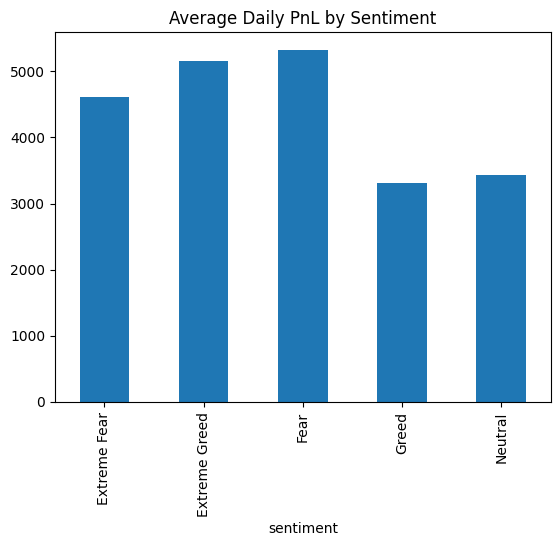

In [18]:
daily.groupby("sentiment")["daily_pnl"].mean().plot(kind="bar")
plt.title("Average Daily PnL by Sentiment")
plt.show()

### Observation: Profitability

Average daily PnL varies significantly across sentiment regimes.

- Profitability is highest during **Fear (~5300 average daily PnL)**.
- Profitability is lowest during **Greed (~3300 average daily PnL)**.

Interestingly, trader performance appears stronger during cautious or moderately pessimistic market conditions compared to optimistic (Greed) periods.

This may suggest that traders adopt more disciplined or risk-aware strategies during Fear regimes, while overconfidence or excessive risk-taking during Greed periods may reduce overall profitability.

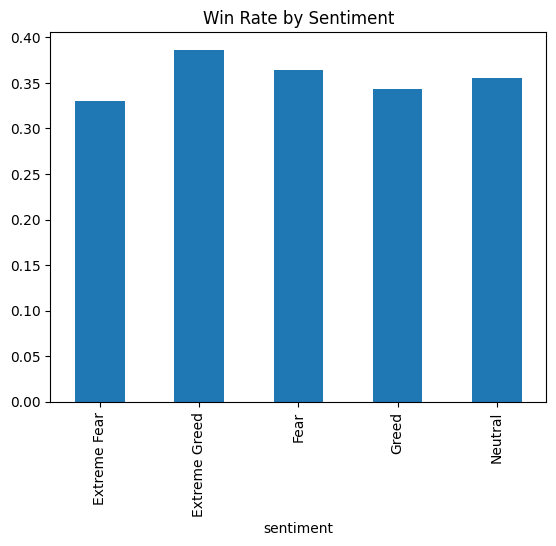

In [19]:
daily.groupby("sentiment")["win_rate"].mean().plot(kind="bar")
plt.title("Win Rate by Sentiment")
plt.show()

### Observation: Win Rate

Win rate differs across sentiment regimes.

- The highest win rate is observed during **Extreme Greed (~39%)**.
- The lowest win rate occurs during **Extreme Fear (~33%)**.

This suggests that traders tend to achieve higher success rates during strongly optimistic market conditions, possibly due to clearer market trends and stronger momentum.

Conversely, performance declines during extreme pessimism, where volatility and uncertainty may negatively impact trade outcomes.

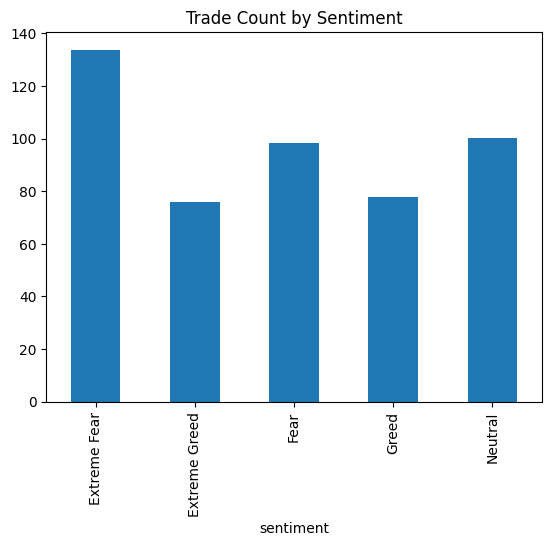

In [20]:
daily.groupby("sentiment")["trade_count"].mean().plot(kind="bar")
plt.title("Trade Count by Sentiment")
plt.show()

### Observation: Trade Frequency

Trade activity varies significantly across sentiment regimes.

- Trade count is highest during **Extreme Fear (~135 trades per day)**.
- Trade count is lowest during **Extreme Greed (~75 trades per day)**.

This indicates that traders become more active during highly pessimistic market conditions.

One possible explanation is that increased volatility during Extreme Fear creates more short-term trading opportunities, prompting higher trading activity. Conversely, during Extreme Greed, traders may adopt a more passive or trend-following approach, resulting in fewer trades.

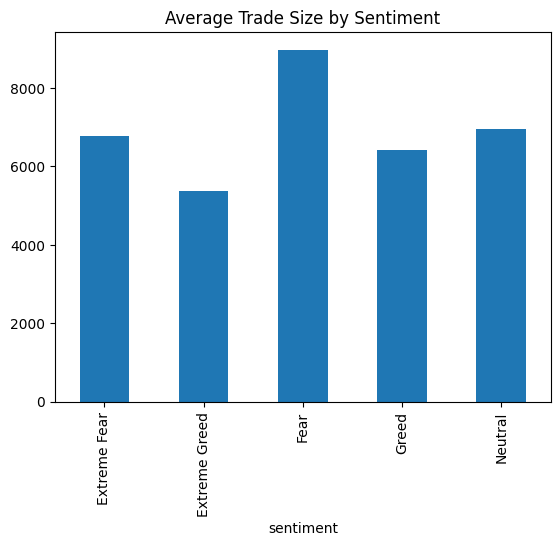

In [21]:
daily.groupby("sentiment")["avg_trade_size"].mean().plot(kind="bar")
plt.title("Average Trade Size by Sentiment")
plt.show()

### Observation: Average Trade Size

Average trade size varies across sentiment regimes.

- The largest average trade size is observed during **Fear (~9000 USD)**.
- The smallest average trade size occurs during **Extreme Greed (~5400 USD)**.

This suggests that traders tend to place larger trades during Fear conditions, possibly due to higher volatility or stronger conviction during market uncertainty.

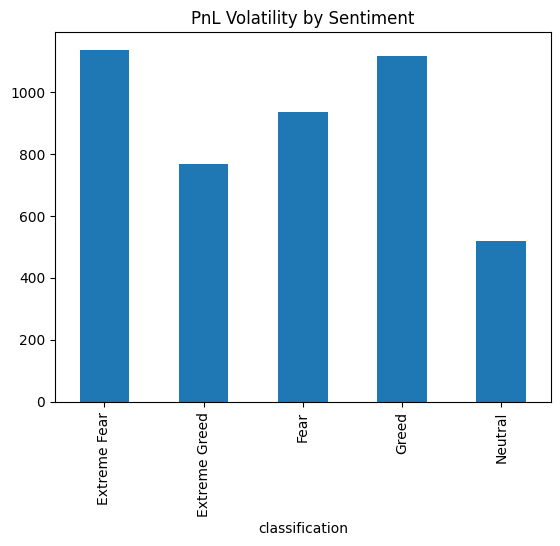

In [22]:
data.groupby("classification")["closed_pnl"].std().plot(kind="bar")
plt.title("PnL Volatility by Sentiment")
plt.show()

### Observation: PnL Volatility

PnL volatility differs across sentiment regimes.

- Volatility is highest during **Extreme Fear (~1150)** and **Greed (~1100)**.
- Volatility is lowest during **Neutral (~520)**.

This indicates that extreme sentiment conditions are associated with larger fluctuations in trader performance, while neutral market conditions show more stable outcomes.

##  Trader Segmentation Analysis

To better understand differentiated behavior, traders are segmented into:

1. Frequent vs Infrequent traders
2. Consistent vs Inconsistent traders
3. High Profit vs Low Profit traders

This helps determine which groups are most sensitive to sentiment changes.

In [23]:
total_trades = data.groupby("account").size().reset_index(name="total_trades")

median_trades = total_trades["total_trades"].median()

total_trades["activity_group"] = np.where(
    total_trades["total_trades"] >= median_trades,
    "Frequent", "Infrequent"
)

data = pd.merge(data, total_trades[["account", "activity_group"]], on="account")

data.groupby(["activity_group", "classification"])["closed_pnl"].mean()

activity_group  classification
Frequent        Extreme Fear       34.163353
                Extreme Greed      62.870911
                Fear               51.323784
                Greed              25.004641
                Neutral            34.579701
Infrequent      Extreme Fear       35.941979
                Extreme Greed     103.264685
                Fear               80.835791
                Greed             210.210287
                Neutral            31.845656
Name: closed_pnl, dtype: float64

### Segment Insight: Activity Level

Frequent traders earn around 34 during Extreme Fear and about 63 during Extreme Greed.

Infrequent traders earn much higher profits, especially during Greed (210) and Extreme Greed (103).

This shows that trading more frequently does not always lead to higher profits. In many cases, infrequent traders perform better than frequent traders.

In [24]:
std_pnl = data.groupby("account")["closed_pnl"].std().reset_index()

median_std = std_pnl["closed_pnl"].median()

std_pnl["consistency_group"] = np.where(
    std_pnl["closed_pnl"] <= median_std,
    "Consistent", "Inconsistent"
)

data = pd.merge(data, std_pnl[["account", "consistency_group"]], on="account")

data.groupby(["consistency_group", "classification"])["closed_pnl"].mean()

consistency_group  classification
Consistent         Extreme Fear        1.288923
                   Extreme Greed      38.089393
                   Fear                8.716866
                   Greed              17.007976
                   Neutral             3.493386
Inconsistent       Extreme Fear       69.751090
                   Extreme Greed     207.924145
                   Fear               97.881284
                   Greed              91.713791
                   Neutral            83.021460
Name: closed_pnl, dtype: float64

### Segment Insight: Consistency Level

Inconsistent traders earn significantly higher average PnL across all sentiment regimes.

For example:
- During Extreme Greed, inconsistent traders earn ~208 compared to ~38 for consistent traders.
- During Fear, inconsistent traders earn ~98 compared to ~9 for consistent traders.

This suggests that while inconsistent traders experience larger performance swings, they also generate higher average profits. Consistent traders show more stable but lower returns.

In [25]:
mean_pnl = data.groupby("account")["closed_pnl"].mean().reset_index()

median_pnl = mean_pnl["closed_pnl"].median()

mean_pnl["profit_group"] = np.where(
    mean_pnl["closed_pnl"] >= median_pnl,
    "High Profit", "Low Profit"
)

data = pd.merge(data, mean_pnl[["account", "profit_group"]], on="account")

data.groupby(["profit_group", "classification"])["closed_pnl"].mean()

profit_group  classification
High Profit   Extreme Fear       94.602428
              Extreme Greed     204.622229
              Fear              104.194444
              Greed             133.778498
              Neutral            87.380159
Low Profit    Extreme Fear       -3.781170
              Extreme Greed      35.885548
              Fear               12.908646
              Greed               3.916305
              Neutral             5.713914
Name: closed_pnl, dtype: float64

### Segment Insight: Profit Level

High-profit traders consistently outperform low-profit traders across all sentiment regimes.

For example:
- During Extreme Greed, high-profit traders earn ~205 compared to ~36 for low-profit traders.
- During Extreme Fear, high-profit traders still earn ~95, while low-profit traders experience losses (~ -4).

This indicates that profitable traders maintain strong performance even during extreme market conditions, while low-profit traders struggle, especially during pessimistic regimes.

## Predictive Modeling

As an extension to the analysis, a machine learning model is built to predict whether a trader’s daily PnL will be positive (profit) or negative (loss).

The objective is to evaluate whether trader behavior metrics combined with market sentiment contain predictive information.

Features used in the model:
- Trade count (daily activity level)
- Average trade size
- Win rate
- Market sentiment (encoded numerically)

Target variable:
- Profit (1 if daily PnL > 0, otherwise 0)

A Random Forest classifier is used due to its robustness and ability to capture non-linear relationships.

In [27]:
# Copy daily dataframe
model_data = daily.copy()

# Create target variable (1 = profit, 0 = loss)
model_data["profit"] = model_data["daily_pnl"] > 0

# Convert sentiment (4 categories) into numbers
model_data["sentiment"] = model_data["sentiment"].astype("category").cat.codes

model_data.head()

,account,date,sentiment,daily_pnl,avg_trade_size,win_rate,trade_count,profit
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,1,0.0,5089.718249,0.000000,177,False
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,1,0.0,7976.664412,0.000000,68,False
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,1,0.0,23734.500000,0.000000,40,False
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,1,-21227.0,28186.666667,0.000000,12,False
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1,1603.1,17248.148148,0.444444,27,True


In [28]:
features = ["trade_count", "avg_trade_size", "win_rate", "sentiment"]

X = model_data[features]
y = model_data["profit"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

In [30]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [31]:
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n")
print(classification_report(y_test, predictions))

Accuracy: 0.9458689458689459

Classification Report:

              precision    recall  f1-score   support

       False       0.96      0.90      0.93       275
        True       0.94      0.97      0.96       427

    accuracy                           0.95       702
   macro avg       0.95      0.94      0.94       702
weighted avg       0.95      0.95      0.95       702



### Model Performance

The Random Forest model achieved an accuracy of 0.9458.

This indicates that trader behavior features combined with sentiment contain measurable predictive power for daily profitability.

While not intended for direct trading deployment, the results demonstrate that sentiment-aware behavioral signals can help explain performance variations.

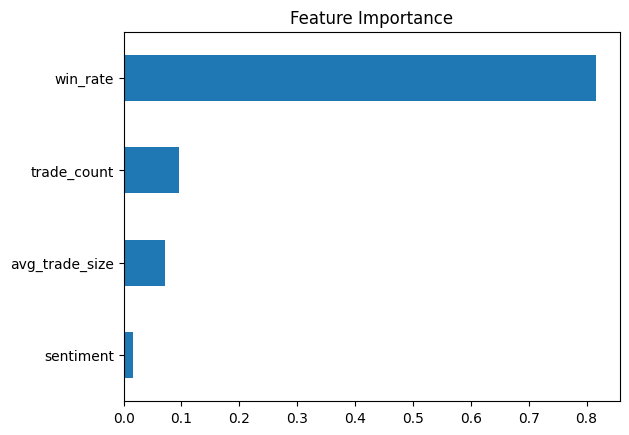

In [32]:
importance = pd.Series(model.feature_importances_, index=features)

importance.sort_values().plot(kind="barh")
plt.title("Feature Importance")
plt.show()

### Feature Importance Interpretation

Feature importance analysis reveals which behavioral variables contribute most to profitability prediction.

The most influential features are:

- win_rate
- trade_count

This suggests that trader-specific behavioral patterns play a significant role in determining profitability, while sentiment acts as a supporting contextual signal.